Numerical simulation of the double pendulum using adaptive time step Runge-Kutta method. The acceleration for each point mass is derived by Lagrangian mechanics. 

$$L = \frac{m_1 +m_2}{2}l_1^2\dot{\theta_1^2} +\frac{m_2}{2}l_2^2 \dot{\theta_2^2} +m_2gl_2cos\theta_2 +m_2l_1l_2\dot{\theta_1}\dot{\theta_2}cos(\theta_1 - \theta_2) (m_1 +m_2)gl_1cos\theta_1$$

$$\frac{\partial L}{\partial \dot{\theta_1}} = m_1l_1^2\dot{\theta_1} + m_2l_1l_2cos(\theta_1 - \theta_2)$$

$$\frac{d}{dt}\left(\frac{\partial L}{\partial \dot{\theta_1}}\right) = (m_1 + m_2)l_1^2\ddot{\theta_1} +m_2l_1l_2\ddot{\theta_2}cos(\theta_1 - \theta_2) - m_2l_1l_2sin(\theta_1 -\theta_2)(\dot{\theta_1} - \dot{\theta_2}$$

$$\frac{\partial L}{\partial \theta_1} = -l_1sin\theta_1(m_1 + m_2) - m_2l_1l_2\dot{\theta_1}\dot{\theta_2}sin(\theta_1 - \theta_2)$$

Thus, the equation of motion for $\theta_1$ is then,

$$(m_1 + m_2)l_1\ddot{\theta_1} + m_2l_2\ddot{\theta_2}cos(\theta_1 - \theta_2) + m_2l_2\dot{\theta_2^2}sin(\theta_1 - \theta_2) + g(m_1 + m_2)sin\theta_1 = 0$$

Similarly, the equation for $\theta_2$ is,

$$l_2\ddot{\theta_2} + l_1\ddot{\theta_1}cos(\theta_1 - \theta_2) - l_1\dot{\theta_1^2}sin(\theta_1 - \theta_2) + gsin\theta_2 = 0$$

Combining the two equations above, we can solve for $\ddot{\theta_1}$ and $\ddot{\theta_2}$ in terms of $\dot{\theta_1}, \dot{\theta_2}, \theta_1$ and $\theta_2$ with $m_1 = m_2 = m, l_1 = l_2 = l$

$$\alpha_1 = \dot{\omega_1} = \frac{ml\omega_1^2sin\theta cos\theta + mgsin\theta_2cos\theta +ml\omega_2^2sin\theta - 2mgsin\theta_1 }  {2ml -mlcos^2\theta} $$

$$\alpha_2 = \dot{\omega_2} = \frac{-ml\omega_2^2sin\theta cos\theta + 2m(gsin\theta_1cos\theta - l\omega_1^2sin\theta - gsin\theta_2) }  {2ml -mlcos^2\theta}$$

where $\theta = \theta_1 - \theta_2$

In [9]:
# Set up configuration options and special features
from pylab import *

In [10]:
def dinput(input_text) :
    return int(input(input_text))

def finput(input_text) :
    return float(input(input_text))

In [11]:
#from nm4p.rk4 import rk4
#from nm4p.rka import rka

def rk4(x,t,dt,derivsRK,param):
    """Runge-Kutta integrator (4th order)
       Input arguments -
        x = current value of dependent variable
        t = independent variable (usually time)
        dt = step size (usually timestep)
        derivsRK = right hand side of the ODE; derivsRK is the
                  name of the function which returns dx/dt
                  Calling format derivsRK (x,t,param).
        param = extra parameters passed to derivsRK
       Output arguments -
        xout = new value of x after a step of size dt
    """

    half_dt = dt/2
    F1 = derivsRK(x,t,param)
    t_half = t + half_dt
    xtemp = x + half_dt*F1
    F2 = derivsRK(xtemp,t_half,param)
    xtemp = x + half_dt*F2
    F3 = derivsRK(xtemp,t_half,param)
    t_full = t + dt
    xtemp = x + dt*F3
    F4 = derivsRK(xtemp,t_full,param)
    xout = x + dt/6*(F1 + F4 + 2*(F2+F3))
    return xout


def rka(x,t,dt,err,derivsRK,param):
    """Adaptive Runge-Kutta routine
       Inputs
        x          Current value of the dependent variable
        t          Independent variable (usually time)
        dt        Step size (usually time step)
        err        Desired fractional local truncation error
        derivsRK   Right hand side of the ODE; derivsRK is the
                   name of the function which returns dx/dt
                   Calling format derivsRK (x,t,param).
        param      Extra parameters passed to derivsRK
       Outputs
        xSmall     New value of the dependent variable
        t          New value of the independent variable
        dt        Suggested step size for next call to rka
    """

    #* Set initial variables
    tSave, xSave = t, x        # Save initial values
    safe1, safe2 = 0.9, 4.0    # Safety factors
    eps = 1.e-15

    #* Loop over maximum number of attempts to satisfy error bound
    xTemp, xSmall, xBig = empty(len(x)), empty(len(x)), empty(len(x))
    maxTry = 100
    for iTry in range(maxTry):

        #* Take the two small time steps
        half_dt = dt/2
        xTemp = rk4(xSave,tSave,half_dt,derivsRK,param)
        t = tSave + half_dt
        xSmall = rk4(xTemp,t,half_dt,derivsRK,param)

        #* Take the single big time step
        t = tSave + dt
        xBig = rk4(xSave,tSave,dt,derivsRK,param)

        #* Compute the estimated truncation error
        scale = err * (abs(xSmall) + abs(xBig))/2
        xDiff = xSmall - xBig
        errorRatio = max( absolute(xDiff) / (scale + eps) )

        #* Estimate new dt value (including safety factors)
        dt_old = dt
        dt = safe1*dt_old*errorRatio**(-0.2)
        dt = max(dt, dt_old/safe2)
        dt = min(dt, safe2*dt_old)

        #* If error is acceptable, return computed values
        if errorRatio < 1 :
            return array([xSmall, t, dt])

    #* Issue error message if error bound never satisfied
    print('ERROR: Adaptive Runge-Kutta routine failed')
    return array([xSmall, t, dt])

In [147]:
#* Define the gravity derivatives function used by the Runge-Kutta routines
def g_derivs(s,t,GM):
    """Returns right-hand side of Kepler ODE; used by Runge-Kutta routines
       Inputs
         s      State vector [r(1) r(2) v(1) v(2)]
         t      Time (not used)
         GM     Parameter G*M (gravitational const. * solar mass)
       Output
         deriv  Derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    """
    #* Compute acceleration
    r = array([s[0], s[1]])  # Unravel the vector s into position and velocity
    v = array([s[2], s[3]])
#     accel = -GM*r/linalg.norm(r)**3    # Gravitational acceleration
    g = GM
    theta_1 = r[0]; theta_2 = r[1]
    theta = theta_1 - theta_2
    w_1 = v[0]; w_2 = v[1]
    m = 1.0
    l = 0.1
    accel_1 = (m*l*w_1**2*sin(theta)*cos(theta) + m*g*sin(theta_2)*cos(theta) + m*l*w_2**2*sin(theta) - 2*m*g*sin(theta_1))/((2*m*l) - m*l*(cos(theta)**2))
    accel_2 = (-m*l*w_2**2*sin(theta)*cos(theta) + 2*m*(g*sin(theta_1)*cos(theta) - l*w_1**2*sin(theta) - g*sin(theta_2)))/((2*m*l) - m*l*(cos(theta)**2))
    #* Return derivatives [dr(1)/dt dr(2)/dt dv(1)/dt dv(2)/dt]
    derivs = hstack((v,accel_1, accel_2))
#     print(derivs.shape)
#     print(derivs)
    return derivs

In [451]:
def rkadaptive(theta1, theta2, adaptErr, nStep):
    #* Loop over desired number of steps using specified
    #  numerical method.
    # nStep = dinput('Enter number of steps: ')
    # dt = finput('Enter time step (yr): ')
    nStep = nStep
    dt= 0.01
#     adaptErr = 1.0e-10  # Error parameter used by adaptive Runge-Kutta
    time = 0.0
    # NumericalMethod = dinput(
    #     'Choose a numerical method: 1 Euler; 2) Euler-Cromer; 3) Runge-Kutta; 4) Adaptive R-K : ')
    NumericalMethod = 4
    # rplot, thplot, tplot, kinetic, potential = empty(nStep), empty(nStep), empty(nStep), empty(nStep), empty(nStep)           
    # th_old = 0
    rplot,vplot = np.empty((nStep,2))*np.NaN, np.empty((nStep,2))*np.NaN
    theta_1 = radians(theta1) #### change initial angles for different behavior
    theta_2 = radians(theta2)
    r = array([theta_1, theta_2])
    v = np.array([0, 0])
    coords = hstack((r,v)) # used by R-K routines
    for iStep in range(nStep):  

        #* Record position and energy for plotting.
        rplot[iStep] = r
        vplot[iStep] = v


        #* Calculate new position and velocity using desired method.
        if NumericalMethod == 1 :
            accel = -GM*r/linalg.norm(r)**3   
            r += dt*v              # Euler step
            v += dt*accel  
            time += dt    
        elif NumericalMethod == 2 :
            accel = -GM*r/linalg.norm(r)**3   
            v += dt*accel 
            r += dt*v              # Euler-Cromer step
            time += dt     
        elif NumericalMethod == 3 :
            coords = rk4(coords,time,dt,g_derivs,GM)
            r = array(coords[0:3])   # 4th order Runge-Kutta
            v = array(coords[3:6])
            time += dt   
        else : 
            [coords, time, dt] = rka(coords,time,dt,adaptErr,g_derivs,GM)
#             print(coords)
            r = array(coords[0:2])    # Adaptive Runge-Kutta
            v = array(coords[2:4])
    return rplot, vplot

In [863]:
#* Set initial position and velocity of the satellite.
theta_1 = 22
theta_2 = 0
r = radians(array([theta_1, theta_2]))
v = np.array([0, 0])
coords = hstack((r,v)) # used by R-K routines

GM = 9.8 
mass = 1.0             # Mass of satellite 
adaptErr = 1.0e-5   # Error parameter used by adaptive Runge-Kutta


In [864]:
rplot, vplot = rkadaptive(theta_1, theta_2,adaptErr, 1000)

theta1 = degrees(rplot[:,0])
theta2 = degrees(rplot[:, 1])
# convert the range from -180 to 180 degree
# for i in range(20) :
#     theta1[theta1 < -180] += 360
#     theta2[theta2 < -180] += 360
#     theta1[theta1 > 180] -= 360
#     theta2[theta2 > 180] -= 360

In [865]:
rcParams.update({'font.size': 21})

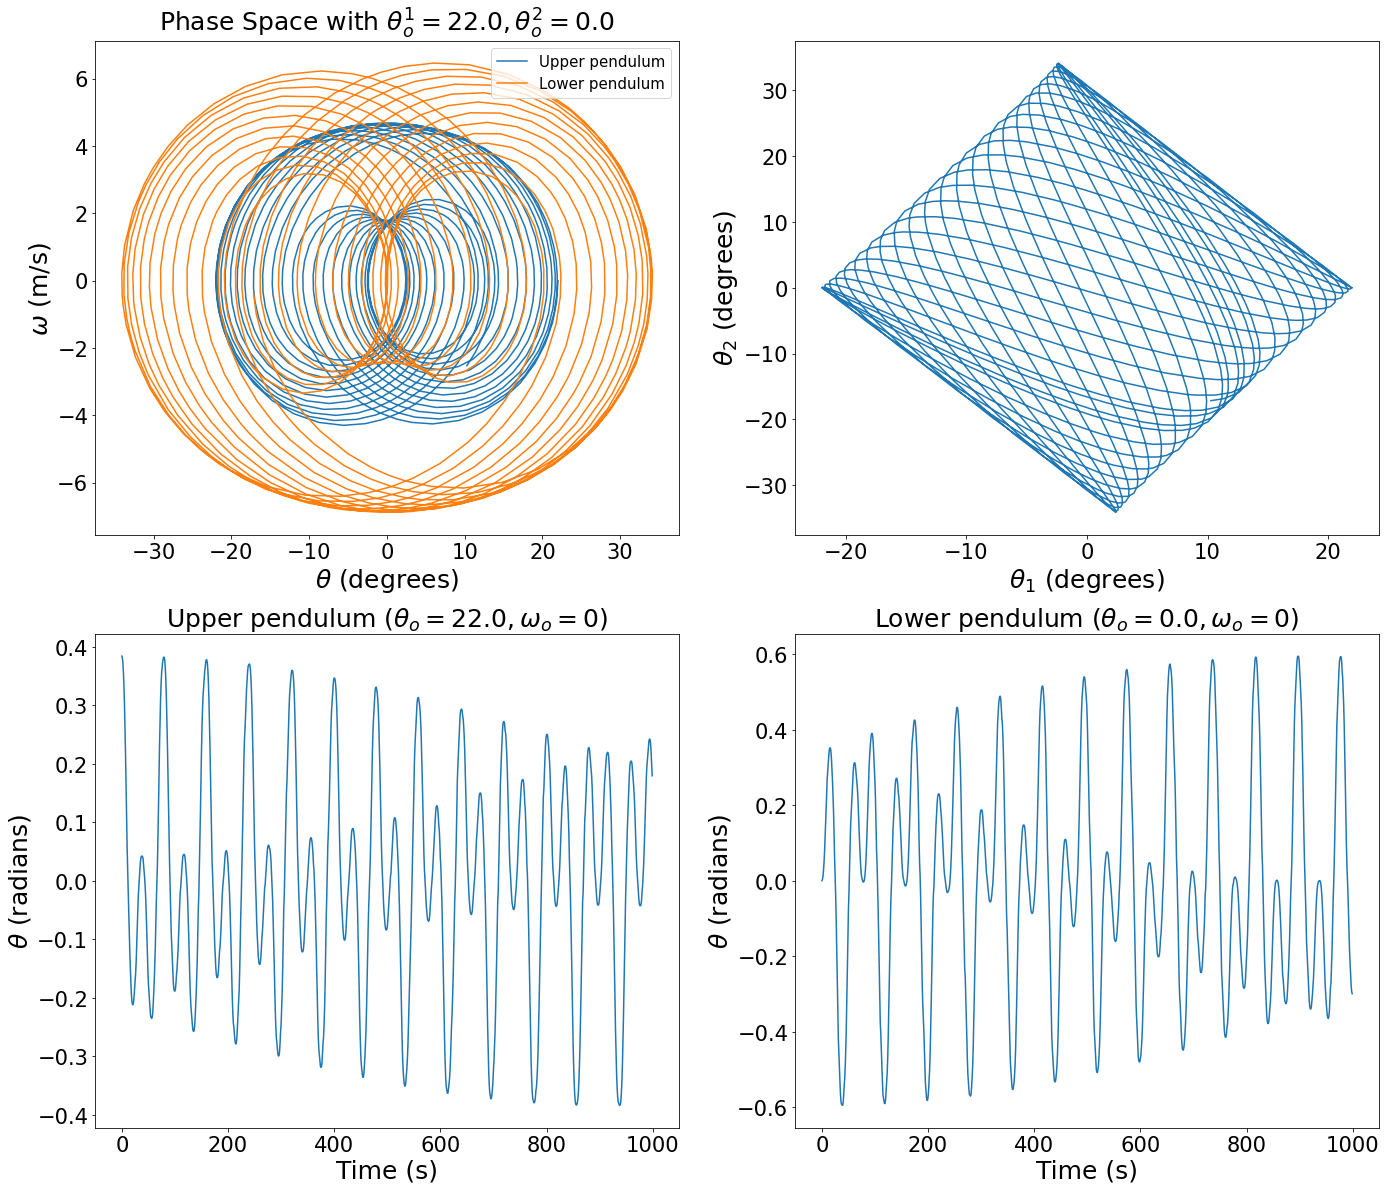

In [866]:
figure(figsize=(23,20))
subplot(2,2,1)
plot(theta1, vplot[:,0],'-', label = 'Upper pendulum')
plot(theta2, vplot[:,1],'-', label = 'Lower pendulum')
title('Phase Space with $\\theta_o^1 = %0.1f, \\theta_o^2 = %0.1f$' % (theta_1, theta_2), fontsize=25)
legend(fontsize=15)
xlabel('$\\theta$ (degrees)', fontsize=25)
ylabel('$\omega$ (m/s)', fontsize = 25)

subplot(2,2,2)
plot(theta1, theta2)
xlabel('$\\theta_1$ (degrees)', fontsize= 25)
ylabel( '$\\theta_2$ (degrees)', fontsize = 25)
# xlim([0,200])
# ylim([0, 500])

subplot(2,2,3)
plot(rplot[:,0])
# plot(theta1)
title('Upper pendulum ($\\theta_o = %0.1f, \omega_o = 0$)'% (theta_1), fontsize=25)
xlabel('Time (s)', fontsize= 25)
ylabel( '$\\theta$ (radians)', fontsize = 25)

subplot(2,2,4)
plot(rplot[:,1])
# plot(theta2)
title('Lower pendulum ($\\theta_o = %0.1f, \omega_o = 0$)'% (theta_2), fontsize=25)
xlabel('Time (s)', fontsize= 25)
ylabel( '$\\theta$ (radians)', fontsize = 25)
show()

In [848]:
# idx1 = np.where((vplot[:,0] > 0) & (abs(theta1) < 0.5))
# x1 = theta2[idx1]
# y1 = vplot[:,1][idx1]
# nStep = 5000
# vpoincare = np.empty([nStep, 10])*NaN
# rpoincare = np.empty([nStep, 10])*NaN
vpoincare1 = {}
rpoincare1 = {}
vpoincare2 = {}
rpoincare2 = {}

In [849]:
angle = [10,11,12,13,14,15]
for i in range(len(angle)):
    theta_1 = angle[i]
    theta_2 = 0
    r = radians(array([theta_1, theta_2]))
    v = np.array([5, 3])
    coords = hstack((r,v)) # used by R-K routines
    GM = 9.8 
    mass = 1.0             # Mass of satellite 
    adaptErr = 1.0e-5  # Error parameter used by adaptive Runge-Kutta
    rplot, vplot = rkadaptive(theta_1, theta_2,adaptErr, 5000)
    theta1 = degrees(rplot[:,0])
    theta2 = degrees(rplot[:, 1])
    idx1 = np.where((vplot[:,0] > 0) & (abs(theta1) < 0.2))
#     idx2 = np.where((vplot[:,0] < 0) & (abs(theta1) < 0.2))
    vpoincare1[angle[i]] = vplot[:,1][idx1]
    rpoincare1[angle[i]] = rplot[:,1][idx1]
#     vpoincare2[angle[i]] = vplot[:,1][idx2]
#     rpoincare2[angle[i]] = rplot[:,1][idx2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


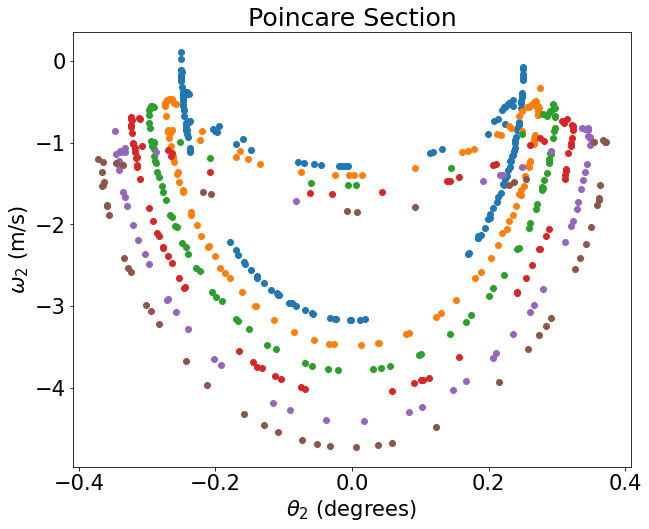

In [850]:
figure(figsize=(10,8))
for i in range(len(angle)):
#     plot(theta2[idx1], vplot[:,1][idx1], '.')
    plot(rpoincare1[angle[i]], vpoincare1[angle[i]], 'o', label = '$\\theta_o^1=$'+ str(angle[i]))
#     plot(rpoincare2[angle[i]], vpoincare2[angle[i]], 'o', label = '$\\theta_o^1=$'+ str(angle[i]))
xlabel('$\\theta_2$ (degrees)')
ylabel('$\omega_2$ (m/s)')
# legend(fontsize=15)
# xlim([-1,1])
# ylim([-10,0])
title('Poincare Section')
show()

In [835]:
angle = [10,11,12,13,14,15]
for i in range(len(angle)):
    theta_1 = angle[i]
    theta_2 = 0
    r = radians(array([theta_1, theta_2]))
    v = np.array([1, 2])
    coords = hstack((r,v)) # used by R-K routines
    GM = 9.8 
    mass = 1.0             # Mass of satellite 
    adaptErr = 1.0e-5  # Error parameter used by adaptive Runge-Kutta
    rplot, vplot = rkadaptive(theta_1, theta_2,adaptErr, 8000)
    theta1 = degrees(rplot[:,0])
    theta2 = degrees(rplot[:, 1])
    idx1 = np.where((vplot[:,0] > 0) & (abs(theta1) < 0.2))
    idx2 = np.where((vplot[:,0] < 0) & (abs(theta1) < 0.2))
    vpoincare1[angle[i]] = vplot[:,1][idx1]
    rpoincare1[angle[i]] = rplot[:,1][idx1]
    vpoincare2[angle[i]] = vplot[:,1][idx2]
    rpoincare2[angle[i]] = rplot[:,1][idx2]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in multiply
  from ipykernel import kernelapp as app


In [857]:
# figure(figsize=(10,11))
# for i in range(len(angle)):
# #     plot(theta2[idx1], vplot[:,1][idx1], '.')
#     plot(rpoincare1[angle[i]], vpoincare1[angle[i]], 'o', label = '$\\theta_o^1=$'+ str(angle[i]))
#     plot(rpoincare2[angle[i]], vpoincare2[angle[i]], 'o', label = '$\\theta_o^1=$'+ str(angle[i]))
# xlabel('$\\theta_2$ (degrees)')
# ylabel('$\omega_2$ (m/s)')
# # legend(fontsize=15)
# # xlim([-1,1])
# # ylim([-10,0])
# title('Poincare Section')
# show()

In [12]:
# from vpython import sphere, rate, vector, color, box
# th_plot = rplot[:,0]
# th_plot2 = rplot[:,1]
# theta0_1 = radians(40)
# theta0_2 = radians(20)
# x_init = 10*sin(theta0_1)
# y_init = 10*(1-cos(theta0_1))
# ball = sphere (pos=vector(x_init,y_init,0), radius=0.8, color=color.green)
# line = box (pos = vector(0,5,0), length=0.3, height=10, width=0.3, color=color.red)
# line.rotate(angle=theta0_1, axis=vector(0,0,1), origin = vector(0,10,0)) #origin is the rotational axis

# ball_2 = sphere (pos=vector(0,0,0), radius=0.8, color=color.blue)
# line_2 = box (pos = vector(ball.pos.x, ball.pos.y-5, 0), length=0.3, height=10, width=0.3, color=color.red)
# line_2.rotate(angle = theta0_2, axis = vector(0,0,1), origin = vector(x_init, y_init, 0))

# x = 10*np.sin(th_plot[1])
# y = 10*(1 - np.cos(th_plot[1]))

# line_2.pos = vector(x, y-5, 0)
# ball.pos = vector(x, y, 0)
# # th_dif2 = th_plot2[1] - th_plot2[0]
# line_2.rotate(angle = 2.0, axis = vector(0,0,1), origin = vector(x, y, 0))


# # for i in range(len(th_plot)-1):
# #     rate(10)
# #     x_old = x
# #     y_old = y
# #     x = 10*np.sin(th_plot[i])
# #     y = 10*(1 - np.cos(th_plot[i]))
# #     ball.pos = vector(x,y,0)
# #     th_dif = th_plot[i+1] - th_plot[i]
# #     line.rotate(angle=th_dif, axis=vector(0,0,1), origin = vector(0,10,0))
# #     th_dif2 = th_plot2[i+1] - th_plot2[i]
# # #     x_old = x_init
# # #     y_old = y_init - 5
# #     line_2.pos = vector(x, y -5, 0)
# #     line_2.rotate(angle=th_dif2, axis=vector(0,0,1), origin = vector(x_old, y_old+10, 0))